In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
df=pd.read_csv("/content/BATASHOE.csv",parse_dates=['DATE'])
df.head()

#       DATE TRADING CODE    LTP*  ...     YCP  TRADE  VALUE (mn)  VOLUME
0  439 2018-05-08     BATASHOE  1123.0  ...  1109.6   40.0        0.58   525.0
1  438 2018-06-08     BATASHOE  1101.0  ...  1109.6   46.0        1.34  1210.0
2  437 2018-07-08     BATASHOE  1108.0  ...  1102.5   24.0        0.60   540.0
3  436 2018-08-08     BATASHOE  1108.0  ...  1107.2    8.0        0.44   396.0
4  435 2018-09-08     BATASHOE  1109.9  ...  1108.3   26.0        3.34  3009.0

[5 rows x 12 columns]

In [2]:
# Sort DataFrame by date
df = df.sort_values('DATE')

# Double check the result
df.head()

#       DATE TRADING CODE    LTP*  ...     YCP  TRADE  VALUE (mn)  VOLUME
36  403 2018-01-10     BATASHOE  1092.0  ...  1094.9   22.0        0.50   451.0
59  380 2018-01-11     BATASHOE  1086.6  ...  1090.9   45.0        0.65   600.0
37  402 2018-02-10     BATASHOE  1093.0  ...  1095.9   17.0        0.26   240.0
79  360 2018-02-12     BATASHOE  1135.6  ...  1131.4   82.0        3.76  3303.0
16  423 2018-03-09     BATASHOE  1110.1  ...  1111.4    1.0        0.00     1.0

[5 rows x 12 columns]

In [3]:
df = df.set_index('DATE')
df.head(3)

# TRADING CODE    LTP*    HIGH  ...     YCP  TRADE  VALUE (mn)  VOLUME
DATE                                          ...                                   
2018-01-10  403     BATASHOE  1092.0  1105.0  ...  1094.9   22.0        0.50   451.0
2018-01-11  380     BATASHOE  1086.6  1095.0  ...  1090.9   45.0        0.65   600.0
2018-02-10  402     BATASHOE  1093.0  1104.0  ...  1095.9   17.0        0.26   240.0

[3 rows x 11 columns]

In [4]:
df['daily_ret'] = df['CLOSEP*'].pct_change()
df['daily_ret'] = df['daily_ret'].fillna(0.0)

In [5]:
df['volatility']= df['daily_ret'].rolling(window=21).std()
df['volatility'] = df['volatility'].fillna(0.0)

In [6]:
df['volatility'] = df['volatility']*100

In [7]:
import matplotlib.pyplot as plt 

In [8]:
df=df.reset_index()['volatility']

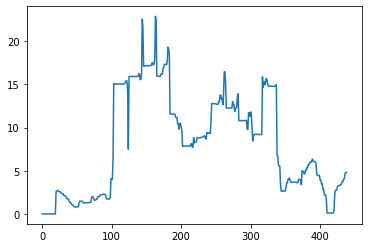

In [9]:
plt.plot(df)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [11]:
df.shape

(439, 1)

In [12]:
##splitting dataset into train and test split where train=70 percent and test=30 percent
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]




In [13]:

training_size,test_size

(307, 132)

In [14]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [],[]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:

print(X_train.shape), print(y_train.shape)

(206, 100)
(206,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
from keras.optimizers import Adam

In [20]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
7/7 [==============================] - 7s 345ms/step - loss: 0.2273 - val_loss: 0.0721
Epoch 2/100
7/7 [==============================] - 1s 128ms/step - loss: 0.0630 - val_loss: 0.0206
Epoch 3/100
7/7 [==============================] - 1s 150ms/step - loss: 0.0318 - val_loss: 0.0293
Epoch 4/100
7/7 [==============================] - 1s 138ms/step - loss: 0.0185 - val_loss: 0.0600
Epoch 5/100
7/7 [==============================] - 1s 147ms/step - loss: 0.0191 - val_loss: 0.0411
Epoch 6/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0168 - val_loss: 0.0410
Epoch 7/100
7/7 [==============================] - 1s 133ms/step - loss: 0.0157 - val_loss: 0.0512
Epoch 8/100
7/7 [==============================] - 1s 132ms/step - loss: 0.0158 - val_loss: 0.0471
Epoch 9/100
7/7 [==============================] - 1s 131ms/step - loss: 0.0148 - val_loss: 0.0433
Epoch 10/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0126 - val_loss: 0.0461
Epoch 11/

In [23]:
from google.colab import drive

In [24]:
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!ls "/content/drive/My Drive"

 Aggression_detection
 annotation
 Annotation-data
 assignment
 assignment1.zip
 assignment.ipynb
 assignment_ML
 assignment_shapna.zip
'BANGLA OCR'
 Classroom
 CNN
'Colab Notebooks'
 conference-template-a4.docx
 consent_form_1721568042.docx
'consent form.docx'
'Cooking vlog-shapna '
 deeplearning
'DevOps Engineer.jpg'
 Diabetes_prediction
'dogs-vs-cats '
'ECO Lecture -3.gdoc'
'emu8086.zip (Unzipped Files)'
 finalExam_cse445.docx
 FinalExam_mst.shapna-akter_1721568042.docx
 finalNepal.xls
 finalreport.rtf
 full_traindata.zip
 FUwangfood.ipynb
'Getting started.pdf'
'housing price prediction'
 housingPrice_testDataHandle.ipynb
 implementation_LSTM
 LAB2_1721568042.zip
 LAB4_1721568042.zip
 labeledTrainData.tsv
 mask
'mid -missing part.pdf'
 midterm_1721568042.docx
 midterm_ML
 ML_midterm_1721568042.docx
 ModelFile.zip
'mst shapna akter_1721568042.docx'
 mst_shapna_akter_1721568042.docx
 mst.shapna-akter_1721568042.docx
'mst shapna akter-1721568042-sec09.pdf'
 mst.shapna-akter_1721568042.

In [26]:
filepath = "/content/drive/MyDrive/stock price_LSTM/modelsBATASHOE/model.h5"
model.save(filepath)
from keras.models import load_model
f1 = '/content/drive/MyDrive/stock price_LSTM/modelsBATASHOE/model.h5'
model = load_model(f1)

In [27]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [28]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [29]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
X = np.reshape(ytest,(1, ytest.size))
Y_test =scaler.inverse_transform(X)

In [30]:
Y_test = Y_test.transpose()
RMSE = math.sqrt(mean_squared_error(Y_test,test_predict))
RMSE

7.710703321440726

In [31]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test,test_predict)
print('MAE: %f' % mae)

MAE: 7.595766


In [ ]:
Y_test

array([[2.21153079],
       [2.2089392 ],
       [1.52635739],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.10509743],
       [0.42252864],
       [2.19797101],
       [2.74857836],
       [2.74857836],
       [2.77935093],
       [3.17764741],
       [3.24681629],
       [3.28206818],
       [3.28206818],
       [3.37756298],
       [3.38942514],
       [3.58561286],
       [3.74520172],
       [3.75756013],
       [4.04013934],
       [4.12957771],
       [4.71542038],
       [4.76492333]])

In [ ]:
test_predict

array([[ 9.336334 ],
       [ 9.232252 ],
       [ 9.13552  ],
       [ 9.034463 ],
       [ 8.894337 ],
       [ 8.727523 ],
       [ 8.556748 ],
       [ 8.401698 ],
       [ 8.274812 ],
       [ 8.181341 ],
       [ 8.121056 ],
       [ 8.090515 ],
       [ 8.083967 ],
       [ 8.095633 ],
       [ 8.128685 ],
       [ 8.226957 ],
       [ 8.3968935],
       [ 8.611624 ],
       [ 8.839248 ],
       [ 9.064785 ],
       [ 9.272462 ],
       [ 9.450731 ],
       [ 9.593241 ],
       [ 9.702084 ],
       [ 9.780797 ],
       [ 9.8399105],
       [ 9.889006 ],
       [ 9.931028 ],
       [ 9.974922 ],
       [10.022704 ],
       [10.088695 ]], dtype=float32)

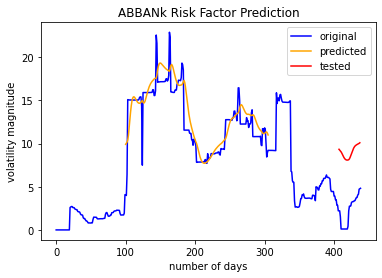

In [ ]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df),color ='blue', label ='original')
plt.plot(trainPredictPlot, color ='orange', label ='predicted')
plt.plot(testPredictPlot , color ='red', label ='tested')
#plt.show()
plt.xlabel('number of days')
plt.ylabel('volatility magnitude')
plt.title('ABBANk Risk Factor Prediction')
plt.legend(loc='best')
plt.show(block=False)


In [ ]:
len(test_data)

132

In [ ]:

x_input=test_data[32:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)


[0.44808832]
101
1 day input [0.24840994 0.24084017 0.24096392 0.14689547 0.11517199 0.11719763
 0.11718937 0.11411025 0.11495639 0.11503528 0.11932236 0.13677069
 0.15822352 0.159194   0.17768744 0.17736957 0.18190739 0.16740426
 0.16090703 0.16006709 0.15989188 0.15992915 0.16070089 0.16063766
 0.16086637 0.1609141  0.15927931 0.15778765 0.15770085 0.17538494
 0.17535282 0.17432559 0.168543   0.14791934 0.21826141 0.21503288
 0.21504163 0.20265082 0.20200035 0.22187353 0.22127576 0.2340265
 0.23388595 0.24904847 0.24841739 0.26068575 0.26069064 0.2607839
 0.26974376 0.27805733 0.2658141  0.2658141  0.26567004 0.26138176
 0.25787633 0.20530677 0.19435478 0.19434635 0.19434635 0.19434635
 0.17094988 0.1709745  0.15235556 0.15233624 0.12504054 0.12474064
 0.09664291 0.09664291 0.09652965 0.06670113 0.00459271 0.00459271
 0.00459271 0.00459271 0.00459271 0.00459271 0.00459271 0.00459271
 0.00459271 0.00459271 0.01846431 0.09605035 0.12011164 0.12011164
 0.12145639 0.13886177 0.14188442 0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

In [ ]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [ ]:
day_pred

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110])

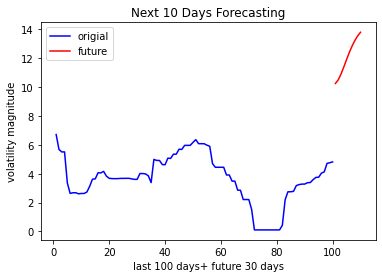

In [ ]:

plt.plot(day_new,scaler.inverse_transform(df[339:]),color ='blue', label ='origial')
plt.plot(day_pred,scaler.inverse_transform(lst_output),color='red', label='future')
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 10 Days Forecasting')
plt.legend(loc='best')
plt.show(block=False)

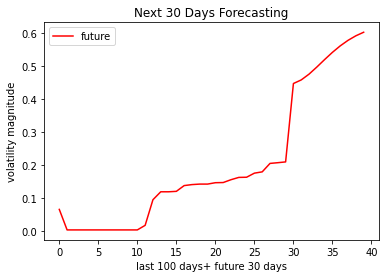

In [ ]:
df3=df.tolist()
df3.extend(lst_output)
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 30 Days Forecasting')
plt.plot(df3[409:],color='red', label='future')
plt.legend(loc='best')
plt.show(block=False)

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

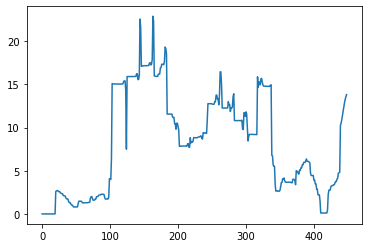

In [ ]:
plt.plot(df3)